In [22]:
import numpy as np
np.random.seed(1001)

import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.cross_validation import StratifiedKFold

%matplotlib inline
matplotlib.style.use('ggplot')

In [12]:
#train = pd.read_csv("../../real_data/train.csv")
#test = pd.read_csv("../../real_data/sample_submission.csv")

In [27]:
train = pd.read_csv("../../Kaggle_data/train.csv")


In [28]:
print("Number of training examples=", train.shape[0], "  Number of classes=", len(train.label.unique()))
print(train.label.unique())

Number of training examples= 9473   Number of classes= 41
['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


In [29]:
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [30]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

In [8]:
class Config(object):
    def __init__(self,
                 sampling_rate=44100, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [7]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


In [18]:
pwd

'/Users/fabian_acustica/Dropbox/FabianCloud/MscAI/SecondSemester/MLP Second Semester/PersonalRepo/MLPProjectAudio'

In [20]:
# JUST RUN ONCE!!
#import wave
#path = '../../data/audio_train'

#maximum_audio_frame = 1323000  # THIS WAS OBTAINED IN A FORMER RUN.

#for audio in train['fname']:
#    wav = wave.open(path + "/" + audio)
#    if wav.getnframes() > maximum_audio_frame:
#        maximum_audio_frame = wav.getnframes()
#print(maximum_audio_frame)

1323000


In [15]:
from scipy.io import wavfile
path = '../../Kaggle_data/audio_train'

maximum_audio_frame = 1323000  # THIS WAS OBTAINED IN A FORMER RUN.

for audio in train['fname']:
    data = wavfile.read(path + "/" + audio)
    data = np.array(data[1][:])
    if data.shape[1] < maximum_audio_frame:
        mul = maximum_audio_frame % len(data)
        


FileNotFoundError: [Errno 2] No such file or directory: '../../Kaggle_data/audio_train/00044347.wav'

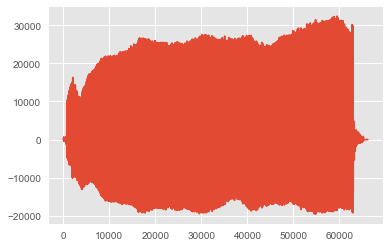

In [39]:
path = '../../Kaggle_Data/audio_train'
from scipy.io import wavfile

prueba= "f776ef0d.wav" #train['fname'][0]
data = wavfile.read(path + "/" + prueba)
data = np.array((data[1][:]))
maximum_audio_frame = 1323000  # THIS WAS OBTAINED IN A FORMER RUN.
mul = maximum_audio_frame % len(data)
plt.plot(data)
plt.show()

In [40]:
data

array([325, 299, 247, ...,  -2,  -3,  -2], dtype=int16)

In [49]:
data = data.astype(float)
mels = librosa.feature.melspectrogram(y=data, sr=44100, n_fft=2048, hop_length=512, power=2.0, n_mels=96,fmax=16000)


In [56]:
## prueba de audio replicado.
mels.shape

(128, 130)

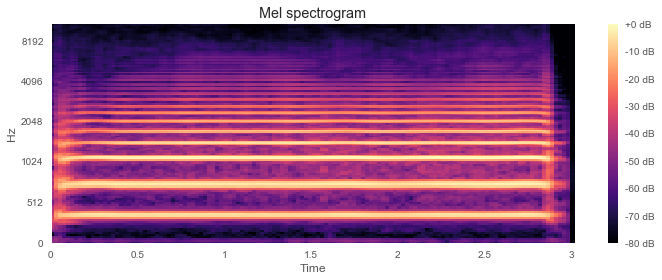

In [52]:
### mel spectrogram plot
import librosa.display
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mels,ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [ ]:
data_new = np.tile(data,mul)

In [ ]:
plt.plot(data_new)

In [54]:
import IPython.display as ipd  # To play sound in the notebook
fname = path + "/" + prueba
ipd.Audio(fname)

In [57]:
def get_fixed_length(audio, number_of_frames):
    if audio.shape[0] > number_of_frames:
        return np.delete(audio, np.arange(number_of_frames, audio.shape[0]), axis=0)
    elif audio.shape[0] < number_of_frames:
        mul = int(round(number_of_frames / audio.shape[0], 0))
        repeated_matrix = np.tile(audio.T, mul).T
        if repeated_matrix.shape[0] > number_of_frames:
            return np.delete(repeated_matrix, np.arange(number_of_frames, repeated_matrix.shape[0]), axis=0)
        return repeated_matrix
    else:
        return audio

In [59]:
get_fixed_length(mels.T, 100).shape

(100, 128)